In [1]:
import os, glob
import matplotlib.pyplot as plt
import cv2
import os, glob
from pathlib import Path

In [2]:
dataset_path = Path("/kaggle/input/lgg-mri-segmentation")
image_size = 128

In [3]:
pairs = []

for image_path in glob.glob(f"{dataset_path}/**/*.tif", recursive=True):
    if not image_path.endswith("_mask.tif"):  
        mask_path = image_path.replace(".tif", "_mask.tif")
        if os.path.isfile(mask_path): 
            pairs.append((image_path, mask_path))
            
print(f"Count of images pairs: {len(pairs)}")

Count of images pairs: 7858


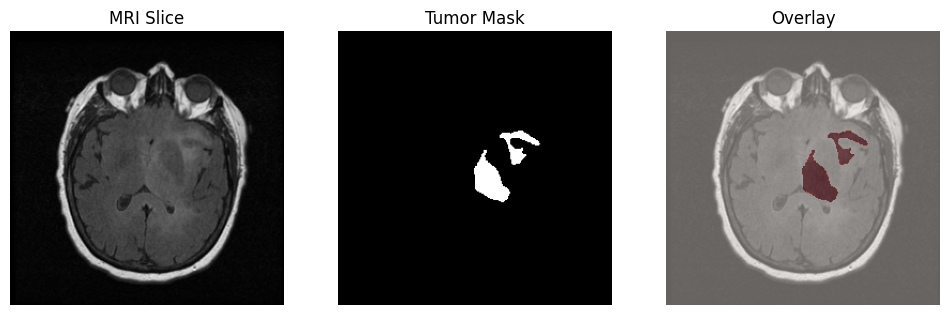

In [4]:
import matplotlib.pyplot as plt
import cv2
import random

img_path, mask_path = pairs[3]

image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)   
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)   

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(image, cmap="gray")
plt.title("MRI Slice")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask, cmap="gray")
plt.title("Tumor Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(image, cmap="gray")
plt.imshow(mask, cmap="Reds", alpha=0.4)  
plt.title("Overlay")
plt.axis("off")

plt.show()


In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(pairs, test_size=0.15, random_state=42)

In [6]:
import os
import random

from collections import defaultdict
patient_dict = defaultdict(list)
for img, mask in pairs:
    patient = os.path.basename(os.path.dirname(img))  # folder name = patient ID
    patient_dict[patient].append((img, mask))

patients = list(patient_dict.keys())
random.shuffle(patients)

split = int(0.85 * len(patients))
train_patients = patients[:split]
val_patients = patients[split:]

train_pairs = [p for pt in train_patients for p in patient_dict[pt]]
val_pairs   = [p for pt in val_patients for p in patient_dict[pt]]

print(f"Train slices: {len(train_pairs)}, Val slices: {len(val_pairs)}")


Train slices: 6628, Val slices: 1230


## DataSet

In [7]:
import numpy as np
from PIL import Image
import torch

from torchvision import datasets, transforms

In [8]:
import numpy as np

def compute_mean_std(pairs):
    pixels = []
    for img_path, _ in pairs:
        img = np.array(Image.open(img_path).convert("L"), dtype=np.float32) / 255.0
        pixels.append(img.flatten())
    pixels = np.concatenate(pixels)
    mean = float(np.mean(pixels))
    std = float(np.std(pixels))
    return mean, std


mean, std = compute_mean_std(train_pairs)
print("Mean:", mean, "Std:", std)


Mean: 0.0856260284781456 Std: 0.12178844958543777


In [9]:
# !pip install albumentations

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from torch.utils.data import Dataset

train_transforms = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.ElasticTransform(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[mean], std=[std]),
    ToTensorV2()
])


class BrainMRIDataset(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]

        img = np.array(Image.open(img_path).convert("L"))  # HxW
        mask = np.array(Image.open(mask_path).convert("L"))

        
        mask = mask / 255.0 if mask.max() > 1 else mask

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask'].unsqueeze(0).float()
        
        return img, mask


# Model - U-Net

In [11]:
import torch
from torch import nn
import torch.nn.functional as F


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm, dropout = 0.0):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))
        if dropout > 0:
            block.append(nn.Dropout2d(dropout))   
            
        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm, dropout = 0.0):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )
            
        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm, dropout = 0.2)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

In [12]:
import torch
from torch import nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=2, depth=4, wf=4, padding=False, batch_norm=False, up_mode='upconv'):

        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm, dropout = 0.2)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

        self.apply(self._init_weights)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, dropout=0.3, base_filters=32):
        super(SimpleUNet, self).__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, base_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters, base_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(base_filters, base_filters*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters*2, base_filters*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        self.pool2 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_filters*2, base_filters*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters*4, base_filters*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*4),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        
        # Decoder
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec4 = nn.Sequential(
            nn.Conv2d(base_filters*4 + base_filters*2, base_filters*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters*2, base_filters*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        
        self.up5 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec5 = nn.Sequential(
            nn.Conv2d(base_filters*2 + base_filters, base_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters, base_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        
        # Output layer
        self.final = nn.Conv2d(base_filters, out_channels, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        c1 = self.enc1(x)
        p1 = self.pool1(c1)
        
        c2 = self.enc2(p1)
        p2 = self.pool2(c2)
        
        # Bottleneck
        c3 = self.bottleneck(p2)
        
        # Decoder
        u4 = self.up4(c3)
        u4 = torch.cat([u4, c2], dim=1)
        c4 = self.dec4(u4)
        
        u5 = self.up5(c4)
        u5 = torch.cat([u5, c1], dim=1)
        c5 = self.dec5(u5)
        
        outputs = self.final(c5)
        return outputs




# model = SimpleUNet(in_channels=1, out_channels=1)
# x = torch.randn(1, 1, 128, 128)  # batch of RGB images
# y = model(x)
# print("Output shape:", y.shape)  # [1, 1, 128, 128]

## Loss - Dice

In [14]:
def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)  # convert logits → probabilities
    pred = pred.view(-1)
    target = target.view(-1)
    
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) /
                (pred.sum() + target.sum() + smooth))


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def tversky_loss(pred, target, alpha=0.2, beta=0.8, smooth=1.0):
    """
    Tversky Loss (generalized Dice with FP/FN control)
    alpha: weight for False Positives
    beta:  weight for False Negatives
    """
    pred = torch.sigmoid(pred)  # convert logits → probabilities
    pred = pred.view(-1)
    target = target.view(-1)
    
    TP = (pred * target).sum()
    FP = ((1 - target) * pred).sum()
    FN = (target * (1 - pred)).sum()
    
    tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)
    return 1 - tversky


In [16]:
def focal_loss(pred, target, alpha=0.25, gamma=2.0):
    """
    Focal Loss for binary segmentation
    alpha: balance between classes
    gamma: focusing parameter
    """
    pred_prob = torch.sigmoid(pred)  # logits → probs
    target = target.view(-1)
    pred_prob = pred_prob.view(-1)
    
    bce = F.binary_cross_entropy(pred_prob, target, reduction='none')
    pt = torch.where(target == 1, pred_prob, 1 - pred_prob)
    focal = alpha * (1 - pt) ** gamma * bce
    return focal.mean()


In [17]:
def focal_tversky_loss(pred, target, alpha=0.3, beta=0.7, gamma=4/3):
    """
    Focal Tversky Loss
    gamma > 1 adds focusing on hard examples
    """
    tversky = 1 - tversky_loss(pred, target, alpha, beta)
    return tversky ** gamma


# BCE + DICE

In [18]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


alpha = 0.65
pos_weight = torch.tensor([6.5]).to(device)
bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

loss_fn_bd = lambda pred, target: (1 - alpha) * bce(pred, target) + alpha * dice_loss(pred, target)

In [19]:
def combined_loss(pred, mask, alpha=0.35, beta=0.5):
    # BCE
    pos_weight = torch.tensor([5.0]).to(device)
    bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)(pred, mask)

    
    # Dice
    smooth = 1e-6
    pred_sig = torch.sigmoid(pred)
    intersection = (pred_sig * mask).sum(dim=(2,3))
    dice = (2. * intersection + smooth) / (pred_sig.sum(dim=(2,3)) + mask.sum(dim=(2,3)) + smooth)
    dice_loss = 1 - dice.mean()
    
    # Tversky
    gamma = 0.75
    TP = (pred_sig * mask).sum(dim=(2,3))
    FP = ((1 - mask) * pred_sig).sum(dim=(2,3))
    FN = (mask * (1 - pred_sig)).sum(dim=(2,3))
    tversky = (TP + smooth) / (TP + gamma*FP + (1-gamma)*FN + smooth)
    tversky_loss = 1 - tversky.mean()
    
    return alpha*bce + beta*dice_loss + (1-alpha-beta)*tversky_loss


# Data-Loader

In [20]:
import matplotlib.pyplot as plt

import torch, gc

gc.collect()  # Python garbage collector
torch.cuda.empty_cache()  # free cached GPU memory


num_epochs = 80
batch_size = 32

factor   = 0.5
patience = 5
start_lr = 4e-3
end_lr   = 1e-6 
plateu_threshold = 1e-4
weight_decay     = 7e-4


from torch.utils.data import DataLoader

train_dataset = BrainMRIDataset(train_pairs, train_transforms)
val_dataset   = BrainMRIDataset(val_pairs, train_transforms)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers = 4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers = 4, pin_memory=True)


def dice_coef(preds, targets, eps=1e-6):
    preds = (torch.sigmoid(preds) > 0.5).float()
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    return ((2. * intersection + eps) / (union + eps)).mean()


In [21]:

# model = UNet(in_channels=1, n_classes=1, padding=True, batch_norm = True ).to(device)
model = SimpleUNet(in_channels=1, out_channels=1, dropout=0.2, base_filters=64).to(device)
# model.load_state_dict(torch.load("best_unet_weights.pth", map_location=device))

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 0.001,
    weight_decay=weight_decay,   
    betas=(0.9, 0.999)   
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode ='min',
    factor = factor,
    patience = patience,
    threshold = plateu_threshold,
    min_lr = end_lr,
    verbose = True
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/80 - Train Loss: 0.6637, Dice Coef Train : 0.1976 |Val Loss: 0.6325, Dice Coef Val: 0.1976 | LR: 0.001000 
Saved Best Model at Epoch 1 with Val DICE: 0.1976
Epoch 2/80 - Train Loss: 0.5416, Dice Coef Train : 0.4837 |Val Loss: 0.6014, Dice Coef Val: 0.4837 | LR: 0.001000 
Epoch 3/80 - Train Loss: 0.4413, Dice Coef Train : 0.6419 |Val Loss: 0.6662, Dice Coef Val: 0.6419 | LR: 0.001000 
Epoch 4/80 - Train Loss: 0.3852, Dice Coef Train : 0.5370 |Val Loss: 0.5245, Dice Coef Val: 0.5370 | LR: 0.001000 
Epoch 5/80 - Train Loss: 0.3510, Dice Coef Train : 0.6495 |Val Loss: 0.4464, Dice Coef Val: 0.6495 | LR: 0.001000 
Epoch 6/80 - Train Loss: 0.3150, Dice Coef Train : 0.7230 |Val Loss: 0.4299, Dice Coef Val: 0.7230 | LR: 0.001000 
Epoch 7/80 - Train Loss: 0.2952, Dice Coef Train : 0.7252 |Val Loss: 0.4579, Dice Coef Val: 0.7252 | LR: 0.001000 
Epoch 8/80 - Train Loss: 0.2747, Dice Coef Train : 0.7229 |Val Loss: 0.5112, Dice Coef Val: 0.7229 | LR: 0.001000 
Epoch 9/80 - Train Loss: 0.254

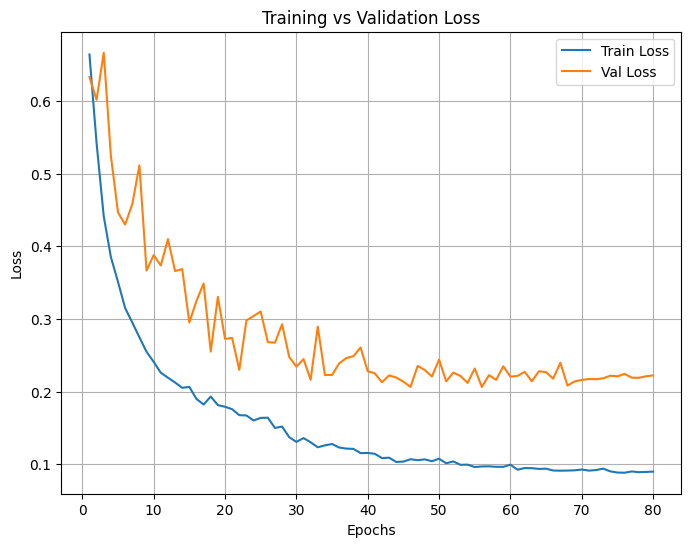

In [22]:
import torch

train_losses = []
val_losses = []
best_val_loss = 100

loss_fn = loss_fn_bd#combined_loss


for epoch in range(num_epochs):
    
    # === Training ===
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_acc += dice_coef(outputs, masks)

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc  = train_acc / len(train_loader)
    train_losses.append(avg_train_loss)

    # === Validation ===
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

            
            val_acc += dice_coef(outputs, masks)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc  = val_acc / len(val_loader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {avg_train_loss:.4f}, Dice Coef Train : {avg_val_acc:.4f} |"
          f"Val Loss: {avg_val_loss:.4f}, Dice Coef Val: {avg_val_acc:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f} ")

    # === Save best model ===
    if avg_val_acc < best_val_loss:
        best_val_loss = avg_val_acc
        torch.save(model.state_dict(), "best_unet_weights.pth")
        print(f"Saved Best Model at Epoch {epoch+1} with Val DICE: {avg_val_acc:.4f}")



# == Plot Learning Curves ==
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()





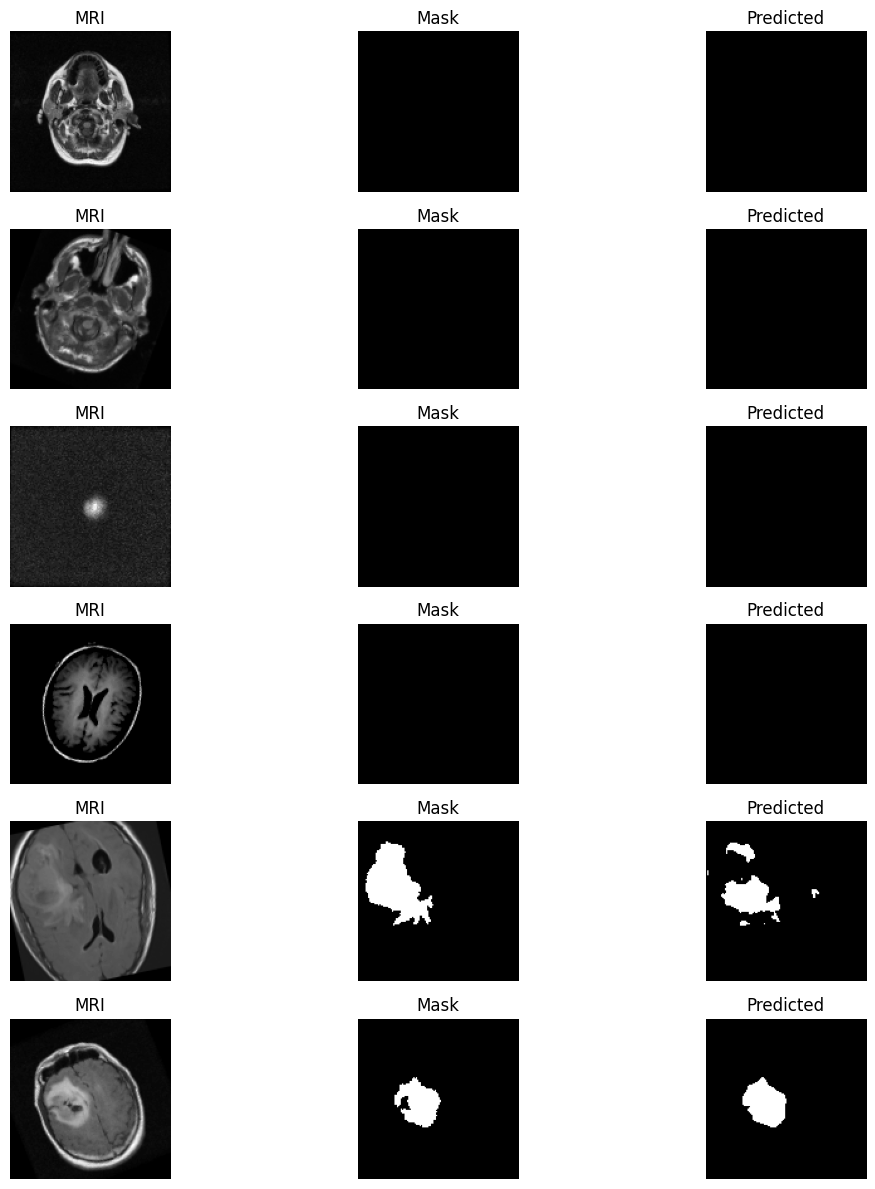

In [23]:
import matplotlib.pyplot as plt
import random
import torch

def dice_score(pred, target, eps=1e-6):
    pred = pred > 0.5
    target = target > 0.5
    intersection = (pred & target).sum().item()
    return (2.0 * intersection) / (pred.sum().item() + target.sum().item() + eps)

def iou_score(pred, target, eps=1e-6):
    pred = pred > 0.5
    target = target > 0.5
    intersection = (pred & target).sum().item()
    union = (pred | target).sum().item()
    return intersection / (union + eps)

model.eval()

indices = random.sample(range(len(val_dataset)), 6)

plt.figure(figsize=(12, 12))

with torch.no_grad():
    for i, idx in enumerate(indices):
        img, mask = val_dataset[idx]
        
        # model expects batch dimension
        pred = model(img.unsqueeze(0).to(device))
        pred = torch.sigmoid(pred).cpu().squeeze().numpy()
        
        # calculate metrics
        dice = dice_score(pred, mask.numpy())
        iou = iou_score(pred, mask.numpy())

        # plot MRI
        plt.subplot(6, 3, i*3 + 1)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title("MRI")
        plt.axis("off")

        # plot Ground Truth mask
        plt.subplot(6, 3, i*3 + 2)
        plt.imshow(mask.squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        # plot Prediction (thresholded)
        plt.subplot(6, 3, i*3 + 3)
        plt.imshow(pred > 0.5, cmap="gray")
        plt.title(f"Predicted\nDice={dice:.3f}, IoU={iou:.3f}")
        plt.axis("off")

plt.savefig("mri_predictions.png", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()
